In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

# Load spectral data

In [2]:
# Load data
data_dict =  load_split_pool(1346, 430, 10, scale = True)

# Pooled X data
train_df_pooled = data_dict["x_pooled"]["train"]
val_df_pooled = data_dict["x_pooled"]["val"]

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


# Load physical data

In [3]:
# load physical data

phys_var_cols = ['virial_rad', 'stellar_rad', 'impact', 'mass', 'disc']
phys_val = pd.DataFrame(data_dict["y"]["val"])
phys_val.columns = phys_var_cols 
phys_val.drop("mass", axis = 1, inplace = True)

# phys_val[["virial_rad", "stellar_rad"]] = np.log10(phys_val[["virial_rad", "stellar_rad"]])
phys_val.head()

scaler_y = StandardScaler()
phys_val_std = scaler_y.fit_transform(phys_val)


## Load estimated models from pickled objects

In [3]:
# Principal Component Analysis: load reconstruction losses and objects

file = open('outputs/pca_tau_loss','rb')
pca_tau_loss = pickle.load(file)
file.close()

file = open('outputs/pca','rb')
pca = pickle.load(file)
file.close()

# file = open('outputs/pca_trim','rb')
# pca_trim = pickle.load(file)
# file.close()


### Autoencoder: 4 layers
# Load full object
file = open('outputs/simple_autoenc_object','rb')
autoencoder = pickle.load(file)
file.close()
# Load reconstruction loss
file = open('outputs/simple_autoencoder_loss_finegrid','rb')
autoenc_simple_fineg = pickle.load(file)
file.close()
# Custom activation: load reconstruction loss
file = open('outputs/simple_autoencoder_loss_finegrid_customact','rb')
autoenc_simple_fineg_customact = pickle.load(file)
file.close()
# - some bottleneck sizes did not ru ncorrectly, so load revised loss for these dims:
file = open('outputs/simple_autoencoder_loss_finegrid_customact_dime1234','rb')
simple_autoenc_object_customact_dim1234 = pickle.load(file)
file.close()

### Autoencoder: 6 Layers
# linear activation: reconstr loss 
file = open('outputs/6layer_autoencoder_loss_finegrid','rb')
autoenc_6layer_fineg = pickle.load(file)
file.close()
# custom activation: reconstr loss
file = open('outputs/6layer_autoencoder_loss_finegrid_customact','rb')
autoenc_6layer_fineg_customact = pickle.load(file)
file.close()
# conv 1d unit
file = open('outputs/6layer_autoencoder_loss_finegrid_conv_customact','rb')
autoenc_6layer_conv_fineg_customact = pickle.load(file)
file.close()


# Load VAE losses
loss_vae_gaus_indep_prior =pd.read_csv("outputs/loss_gaussindep.csv")
loss_vae_gaus_mix_prior =pd.read_csv("outputs/loss_gaussmixture.csv")

# import tensorflow as tf
# file = open('outputs/simple_autoenc_object','rb')
# simple_autoenc_object = pickle.load(file)
# file.close()

# Functions

In [5]:

# We need to calculate reconstr loss for sparse PCA as this is not contained in the loaded objects

def rescale_back(observation, mean, std):
    '''
    Reverse standardisation using the given parameters
    '''
    return( observation*std + mean ) 


# Model comparison: reconstruction losses

In [8]:
# Load PCA loss
pca_loss = [ pca["restricted_spaces"][i]["loss"] for i in pca["restricted_spaces"] ]
# pca_trim_loss = [ pca_trim["restricted_spaces"][i]["loss"] for i in pca_trim["restricted_spaces"] ]

In [13]:
# Porcess VAE losses for easier plotting
loss_vae_gaus_indep_prior_dir = dict()
loss_vae_gaus_indep_prior_dir["loss"] = loss_vae_gaus_indep_prior.iloc[1,:].values[1:].astype(float)
loss_vae_gaus_indep_prior_dir["dims"] = [1, 2, 3, 4, 5]


loss_vae_gaus_mix_prior_dir = dict()
loss_vae_gaus_mix_prior_dir["loss"] = loss_vae_gaus_mix_prior.iloc[1,:].values[1:].astype(float)
loss_vae_gaus_mix_prior_dir["dims"] = [1, 2, 3, 4, 5]

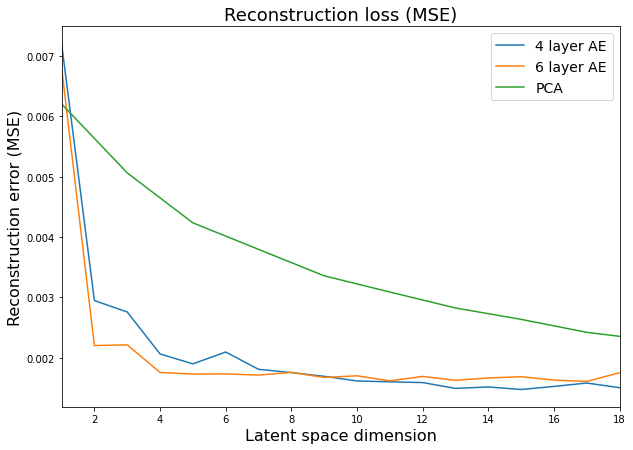

In [9]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(autoenc_simple_fineg["dim"], autoenc_simple_fineg["loss"], label = "4 layer AE")
ax.plot(autoenc_6layer_fineg ["dim"], autoenc_6layer_fineg ["loss"], label = "6 layer AE" )
ax.plot( np.array(np.arange(1, 20, 2)), pca_loss[:len(np.array(np.arange(1, 20, 2)))] , label = "PCA")
ax.set_xlabel("Latent space dimension", fontsize = 16)
ax.set_ylabel("Reconstruction error (MSE)", fontsize = 16)
ax.set(xlim = (1,18) )
ax.set_title("Reconstruction loss (MSE)", fontsize = 18)
ax.legend(fontsize = 14);

(1.0, 5.0)

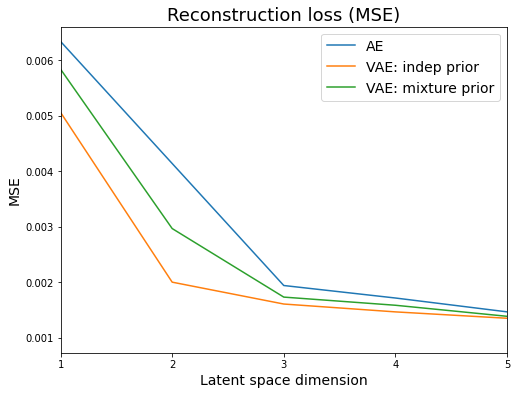

In [14]:
# Plot AE with and without tanh activation 

# Eliminate the two diemsnions for which the tanh model did not converge
autoenc_simple_customact_loss, autoenc_simple_customact_dim = autoenc_simple_fineg_customact["loss"], autoenc_simple_fineg_customact["dim"]
# autoenc_simple_customact_loss[1], autoenc_simple_customact_dim[1] = simple_autoenc_object_customact_dim1234["loss"][2], 2
autoenc_simple_customact_loss[1], autoenc_simple_customact_dim[1] = np.nan, np.nan
autoenc_simple_customact_loss[2] = simple_autoenc_object_customact_dim1234["loss"][2]

autoenc_simple_customact_loss = [x for x in autoenc_simple_customact_loss if not np.isnan(x)]
autoenc_simple_customact_dim = [x for x in autoenc_simple_customact_dim if not np.isnan(x)]


fig, ax = plt.subplots(figsize = (8, 6))
# ax.plot(autoenc_simple_fineg["dim"], autoenc_simple_fineg["loss"], label = "4 layer AE")
# ax.plot(simple_autoenc_object_customact_dim1234["dim"], simple_autoenc_object_customact_dim1234["loss"])
ax.plot(autoenc_simple_customact_dim, autoenc_simple_customact_loss, label = "AE" )
ax.plot(loss_vae_gaus_indep_prior_dir["dims"], loss_vae_gaus_indep_prior_dir["loss"], label = "VAE: indep prior" )
ax.plot(loss_vae_gaus_mix_prior_dir["dims"], loss_vae_gaus_mix_prior_dir["loss"], label = "VAE: mixture prior" )
# ax.plot(simple_autoenc_object_customact_dim1234["loss"] )
# ax.plot( np.array(np.arange(1, 20, 2)), pca_loss[:len(np.array(np.arange(1, 20, 2)))] , label = "PCA")
ax.set_xlabel("Latent space dimension", fontsize = 14)
ax.set_ylabel("MSE", fontsize = 14)
ax.set(xlim = (1,18) )
ax.set_title("Reconstruction loss (MSE)", fontsize = 18)

ax.legend(fontsize = 14);

ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_xlim([1,5])


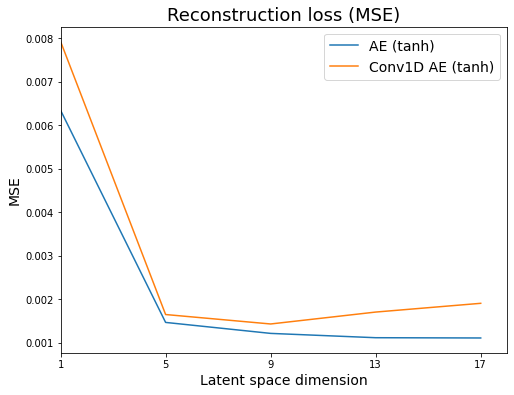

In [15]:
# Plot AE with and without tanh activation 

# include just dims for which Conv1D net was run
index_autoencConv = list(np.array(autoenc_6layer_conv_fineg_customact["dim"])-1)
# subset simple autoencdoer loss accordingly
autoenc_simple_customact_dim_subset = [autoenc_simple_fineg_customact["dim"][i] for i in index_autoencConv]
autoenc_simple_customact_loss_subset = [autoenc_simple_fineg_customact["loss"][i] for i in index_autoencConv]

fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(autoenc_simple_customact_dim_subset, autoenc_simple_customact_loss_subset, label = "AE (tanh)" )
ax.plot(autoenc_6layer_conv_fineg_customact["dim"], 
        autoenc_6layer_conv_fineg_customact["loss"], label = "Conv1D AE (tanh)" )
# ax.plot( np.array(np.arange(1, 20, 2)), pca_loss[:len(np.array(np.arange(1, 20, 2)))] , label = "PCA")
ax.set_xlabel("Latent space dimension", fontsize = 14)
ax.set_ylabel("MSE", fontsize = 14)
ax.set(xlim = (1,18) )
ax.set_title("Reconstruction loss (MSE)", fontsize = 18)
ax.set_xticks(autoenc_6layer_conv_fineg_customact["dim"])
ax.set_xticklabels(autoenc_6layer_conv_fineg_customact["dim"])
ax.legend(fontsize = 14);

# Rescaling errors

Spectral data were standardised when loaded -> we need to standardise them back to their original scale.

Similarly, AE reconstructions  of spectra are on a transforme dscale -> transform them back


In [19]:
# rescale val spectra
val_df_pooled_rescaled = rescale_back(val_df_pooled, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 


# load pca latent space
# pca_val_transformed = pca["restricted_spaces"][50]['x_val_transformed']
# pca_val_transformed_origspace = pca["restricted_spaces"][50]['x_val_original_space_pca']
# Calculate pca errors
pca_errors = (val_df_pooled_rescaled - pca["restricted_spaces"][50]['x_val_original_space_pca']).to_numpy() 

# Calculate Autoencoder reconstruction errors
autoenc_errors = val_df_pooled_rescaled - rescale_back(autoencoder["x_reconstructed_val"], 
                                                     data_dict["parameters"]["mean"], 
                                                     data_dict["parameters"]["std"])

# PCA & AE: comparison of error characteristics

In [20]:
pca_errors_means = pca_errors.mean(axis = 1)
pca_errors_means_std = (pca_errors_means - pca_errors_means.mean())/pca_errors_means.std() 

pca_mean_abserror = np.abs(pca_errors).mean(axis = 0)
pca_std_abserror = pca_mean_abserror.std(axis = 0)

Text(0.5, 0, 'Wavelength')

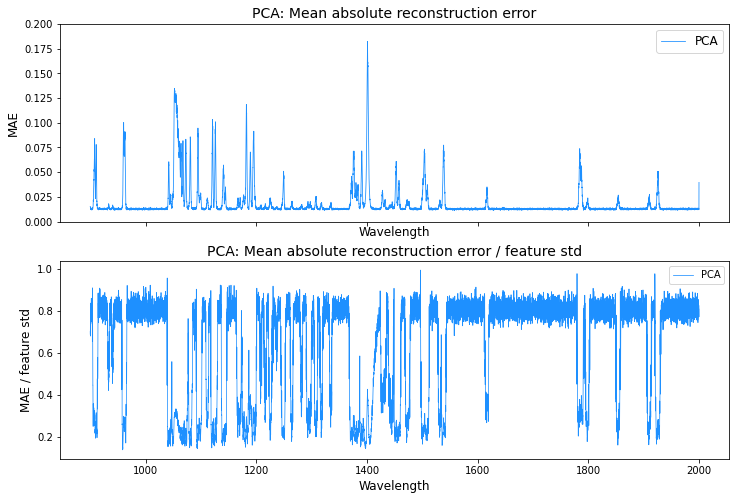

In [21]:
# fig, ax = plt.subplots(figsize = (10, 6))

fig, ax = plt.subplots( 2, 1, sharex = True, figsize = (12, 8) )
ax[0].plot(data_dict["wavelengths"], pca_mean_abserror, color = "dodgerblue", linewidth = 0.8, label = "PCA")
ax[0].legend(fontsize = 12)
ax[0].set_xlabel("Wavelength", fontsize = 12)
ax[0].set_ylabel("MAE", fontsize = 12)
ax[0].set_ylim([0, 0.2])
ax[0].set_title("PCA: Mean absolute reconstruction error", fontsize = 14)
# ax.plot(mean_abserror/mean_abserror.max())
ax[1].plot(data_dict["wavelengths"], pca_mean_abserror/data_dict["parameters"]["std"], linewidth=0.75, color = "dodgerblue", label = "PCA" )
ax[1].legend()
ax[1].set_title("PCA: Mean absolute reconstruction error / feature std", fontsize = 14)
ax[1].set_ylabel("MAE / feature std", fontsize = 12)
ax[1].set_xlabel("Wavelength", fontsize = 12)

Text(0.5, 0, 'Wavelength')

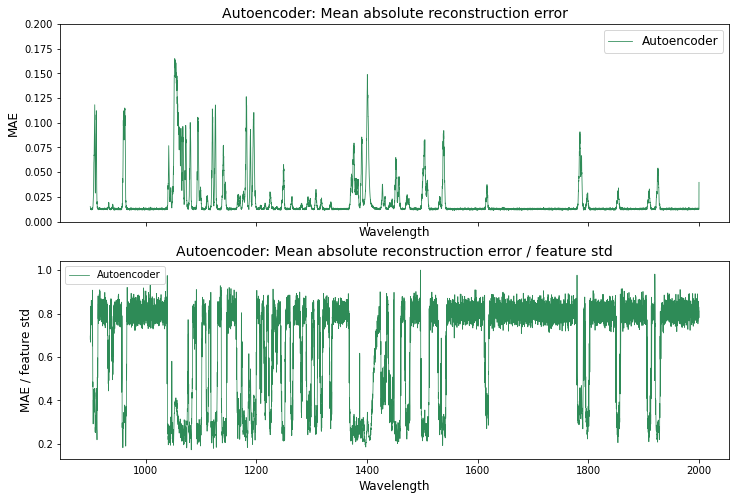

In [22]:
# fig, ax = plt.subplots(figsize = (10, 6))

fig, ax = plt.subplots( 2, 1, sharex = True, figsize = (12, 8) )
ax[0].plot(data_dict["wavelengths"], np.abs(autoenc_errors).mean(axis = 0), color = "seagreen", linewidth = 0.8, label = "Autoencoder")
ax[0].legend(fontsize = 12)
ax[0].set_xlabel("Wavelength", fontsize = 12)
ax[0].set_ylabel("MAE", fontsize = 12)
ax[0].set_ylim([0, 0.2])
ax[0].set_title("Autoencoder: Mean absolute reconstruction error", fontsize = 14)
# ax.plot(mean_abserror/mean_abserror.max())
ax[1].plot(data_dict["wavelengths"], np.abs(autoenc_errors).mean(axis = 0)/data_dict["parameters"]["std"], linewidth=0.75, 
           color = "seagreen", label = "Autoencoder" )
ax[1].legend()
ax[1].set_title("Autoencoder: Mean absolute reconstruction error / feature std", fontsize = 14)
ax[1].set_ylabel("MAE / feature std", fontsize = 12)
ax[1].set_xlabel("Wavelength", fontsize = 12)

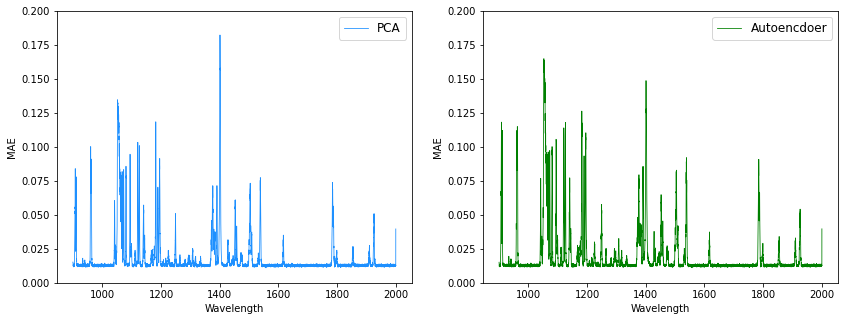

In [23]:
fig, ax = plt.subplots( 1, 2, sharex = True, figsize = (14, 5) )
ax[0].plot(data_dict["wavelengths"], pca_mean_abserror, color = "dodgerblue", linewidth = 0.8, label = "PCA")
ax[0].legend(fontsize = 12)
ax[0].set_xlabel("Wavelength")
ax[0].set_ylabel("MAE")
ax[0].set_ylim([0, 0.2])
# ax[0].set_title("PCA: Mean absolute error vs wavelength", fontsize = 14);
ax[1].plot(data_dict["wavelengths"], np.abs(autoenc_errors).mean(axis = 0), linewidth = 0.8, color = "green", label = "Autoencdoer" )
ax[1].legend(fontsize = 12)
ax[1].set_xlabel("Wavelength")
ax[1].set_ylim([0, 0.2])
ax[1].set_ylabel("MAE");

(0.0, 0.2)

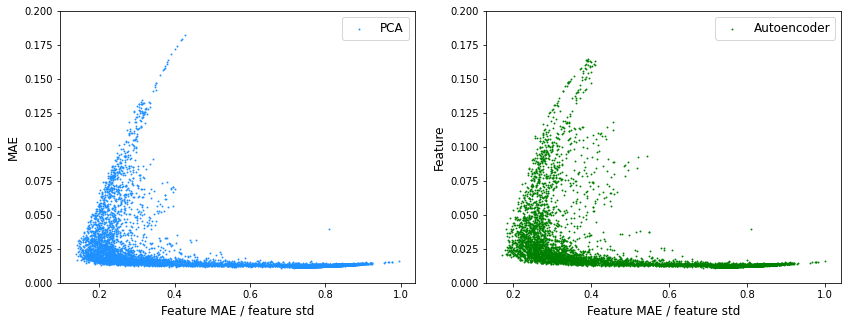

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5) )
ax[0].scatter( pca_mean_abserror/data_dict["parameters"]["std"], pca_mean_abserror, s = 0.8, c = "dodgerblue", label = "PCA" )
ax[0].set_xlabel("Feature MAE / feature std", fontsize = 12)
ax[0].set_ylabel("MAE", fontsize = 12)
# ax[0].set_title("PCA: Mean absolute error vs standardised MAE", fontsize = 14);
ax[0].legend(fontsize = 12);
ax[0].set_ylim([0, 0.2])

ax[1].scatter( np.abs(autoenc_errors).mean(axis = 0) /data_dict["parameters"]["std"], np.abs(autoenc_errors).mean(axis = 0), 
           s = 0.8, color = "green", label = "Autoencoder" )
ax[1].set_xlabel("Feature MAE / feature std", fontsize = 12)
ax[1].set_ylabel("Feature", fontsize = 12);
ax[1].legend(fontsize = 12);
ax[1].set_ylim([0, 0.2])


# PCA: errors and physical properties

In [25]:
pca_errors_means = np.abs(pca_errors).mean(axis = 1)
pca_errors_means_std = (np.abs(pca_errors_means) - pca_errors_means.mean())/pca_errors_means.std() 

In [26]:
# Regress errors on physical properties

import statsmodels.api as sm
import numpy as np

Y = pca_errors_means_std
X = phys_val_std
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# results.params

array([ 1.98192157e-16,  1.64732110e-01,  3.25886055e-02, -3.14981907e-01,
        2.63367012e-01])

In [27]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     31.53
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           5.17e-23
Time:                        12:22:13   Log-Likelihood:                -554.27
No. Observations:                 430   AIC:                             1119.
Df Residuals:                     425   BIC:                             1139.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.982e-16      0.043   4.65e-15      1.0

In [33]:
# For each wavelength, regress errors on physical properties -> 
# -> The coefficients and z-scores will tell us which physical property is important for explaining error at which wavelength


coefs_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
pvals_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
rsquared_array = np.empty(shape = val_df_pooled_rescaled.shape[1])
std_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))

for feature_num in np.arange(0, val_df_pooled_rescaled.shape[1]):
    
    feature = pca_errors[:, feature_num]
    
    feature_std = ( feature - feature.mean() )/ feature.std()
    X = phys_val_std
    X = sm.add_constant(X)
    
    Y = feature_std
    model = sm.OLS(Y,X)
    results = model.fit()
    
    coefs_array[:, feature_num] = results.params
    pvals_array[:, feature_num] = results.pvalues
    std_array[:, feature_num] = results.bse
    rsquared_array[feature_num] = results.rsquared

In [34]:
def numpy_rolling_mean(np_array, window, min_periods = None, index = None):
    '''
    Return a rolling average of a given numpy array. The arguments window and min_periods specify how 
    to construct the rolling windows.
    '''
    df_series = pd.DataFrame(np_array)
    df_series.set_index(index, inplace = True)
    return( df_series.rolling(window, min_periods, center = True).mean() )
    

In [35]:
def plot_coefs_vs_wavelength(coefs, window, min_periods = None, title = None, xticks = None,
                            color = None, color_ma = None, y_lim = [None, None]):
    fig, ax = plt.subplots(figsize = (18, 10))
    ax.plot(xticks, coefs, linewidth=0.1, color = color )
    ax.tick_params(labelsize = 18)
    ax.plot(numpy_rolling_mean(coefs, window, min_periods, xticks), 
            linewidth=0.8, 
            color = color_ma );
    ax.set_ylim(y_lim)
    
    if title: ax.set_title(title, fontsize = 20);
    return()

virial_rad
stellar_rad
impact
disc


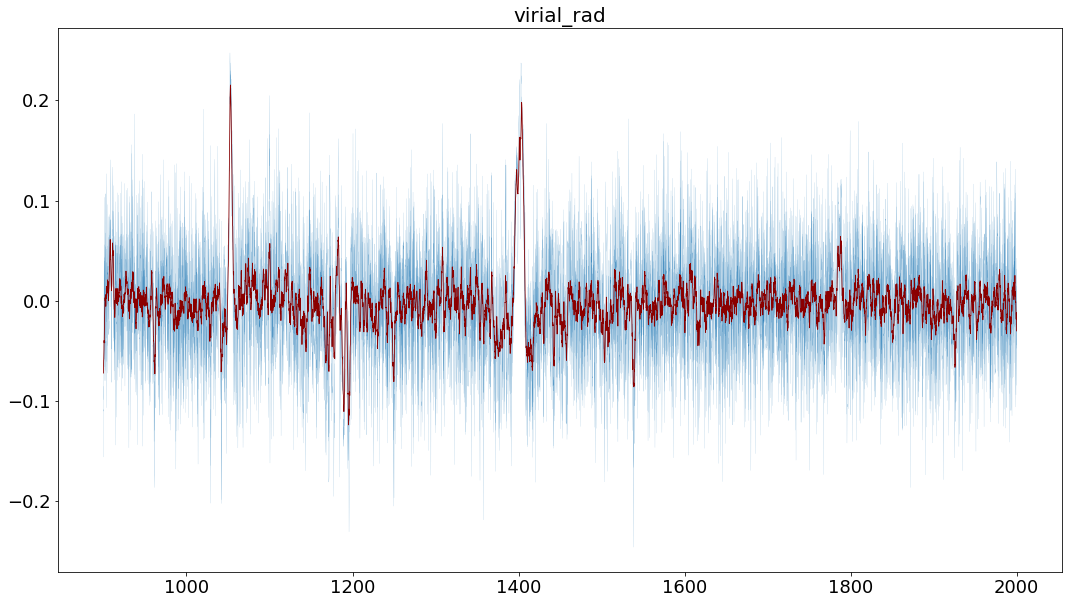

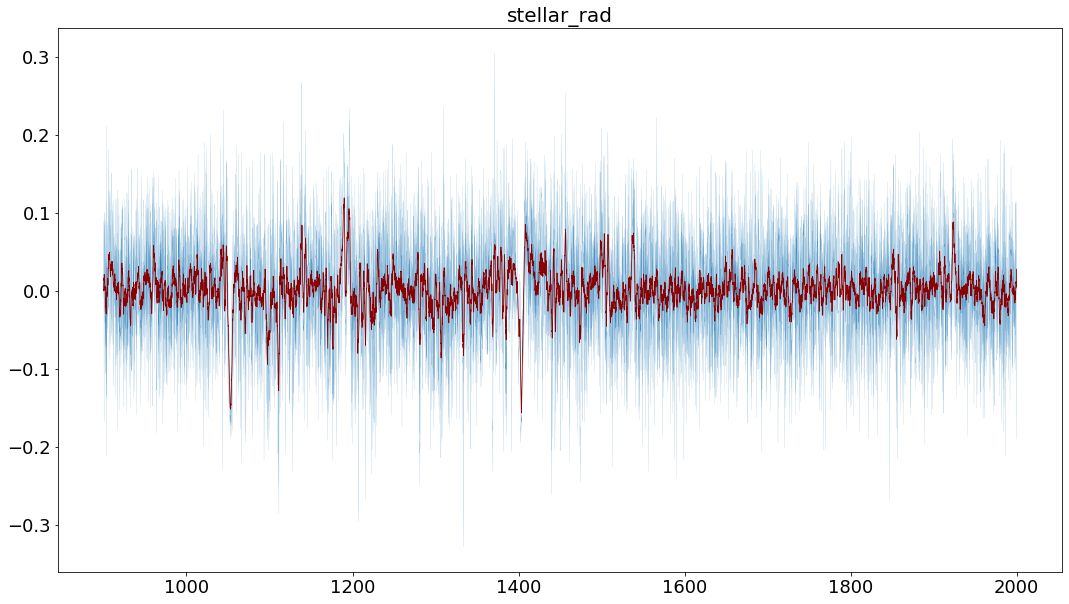

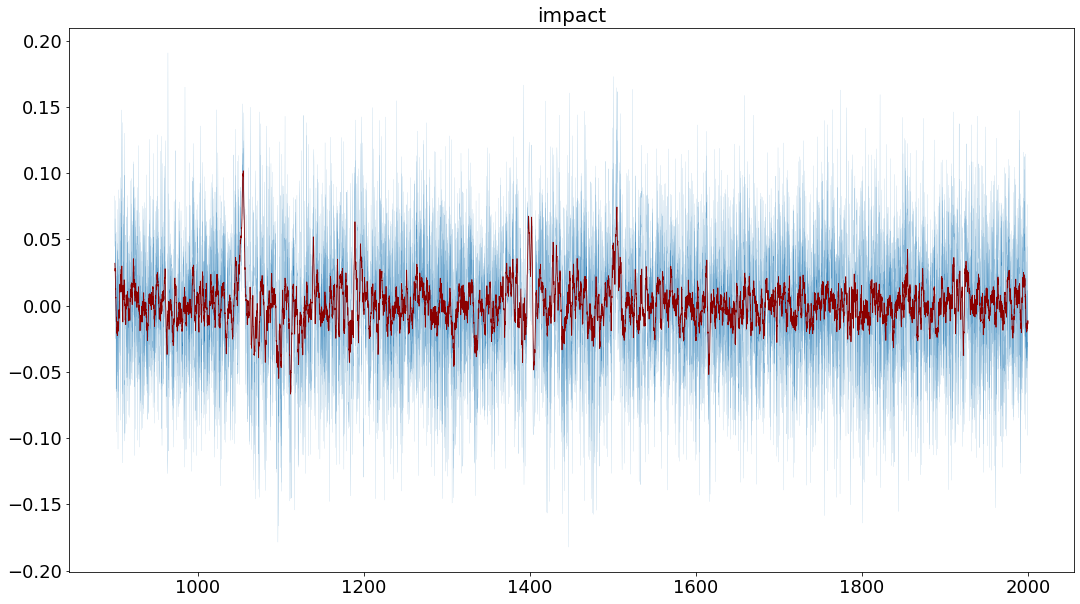

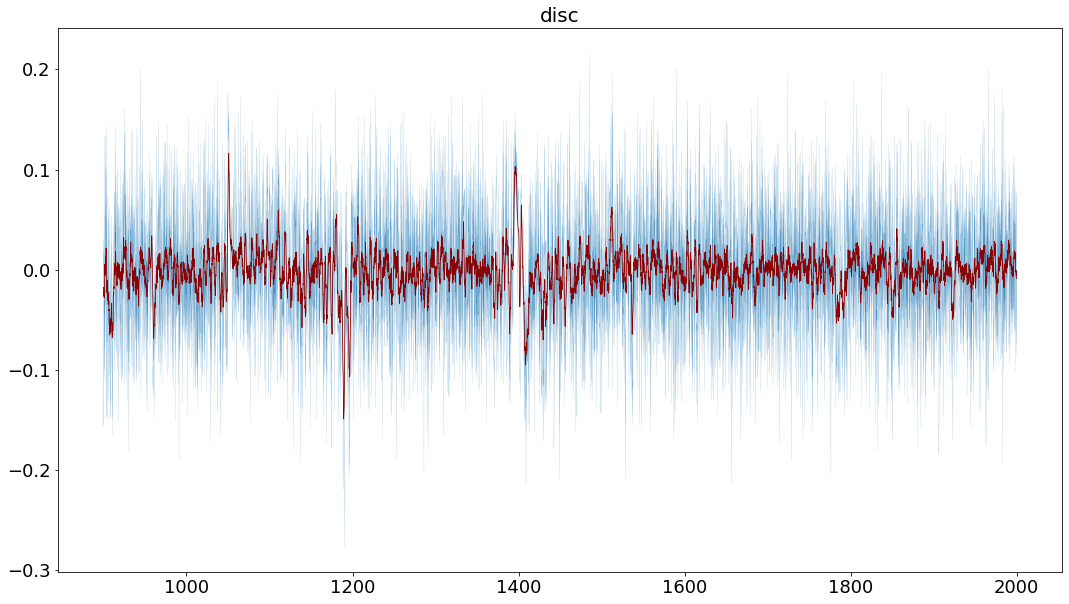

In [36]:
# Plot coefficients of regressions

for i in np.arange(0, 4):

    print(phys_val.columns[i])
#     plot_coefs_vs_wavelength( np.abs(coefs_array[i+1,:])/(std_array[i+1,:]), 20, 10, title = phys_val.columns[i], 
#                              xticks = pooled_wavelengths, color_ma = "darkred", y_lim = [0, 4]) 
    plot_coefs_vs_wavelength( (coefs_array[i+1,:]), 20, 10, title = phys_val.columns[i], 
                             xticks = data_dict["wavelengths"], color_ma = "darkred") 

virial_rad
stellar_rad
impact
disc


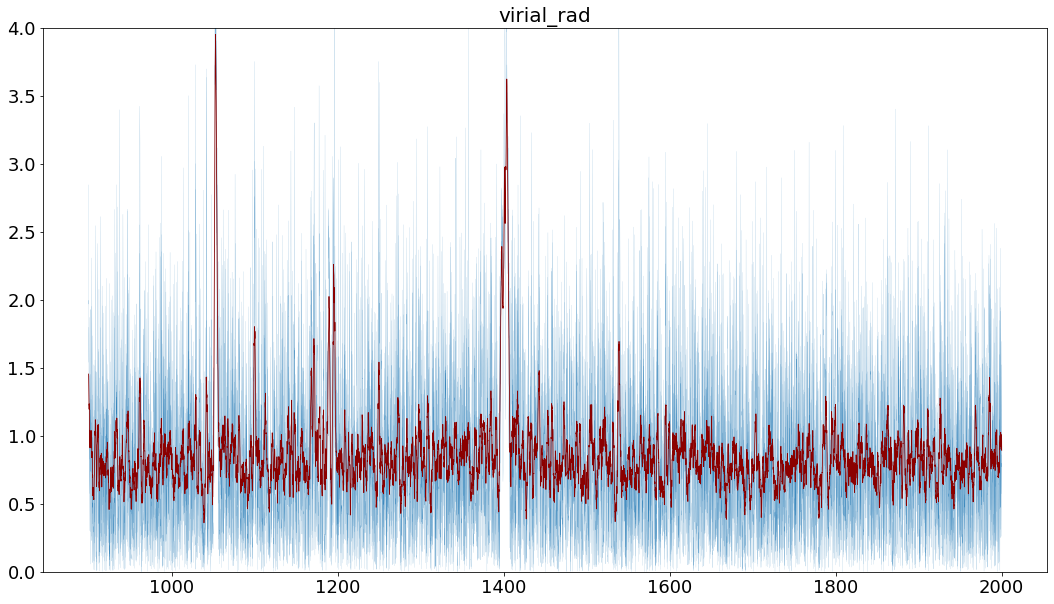

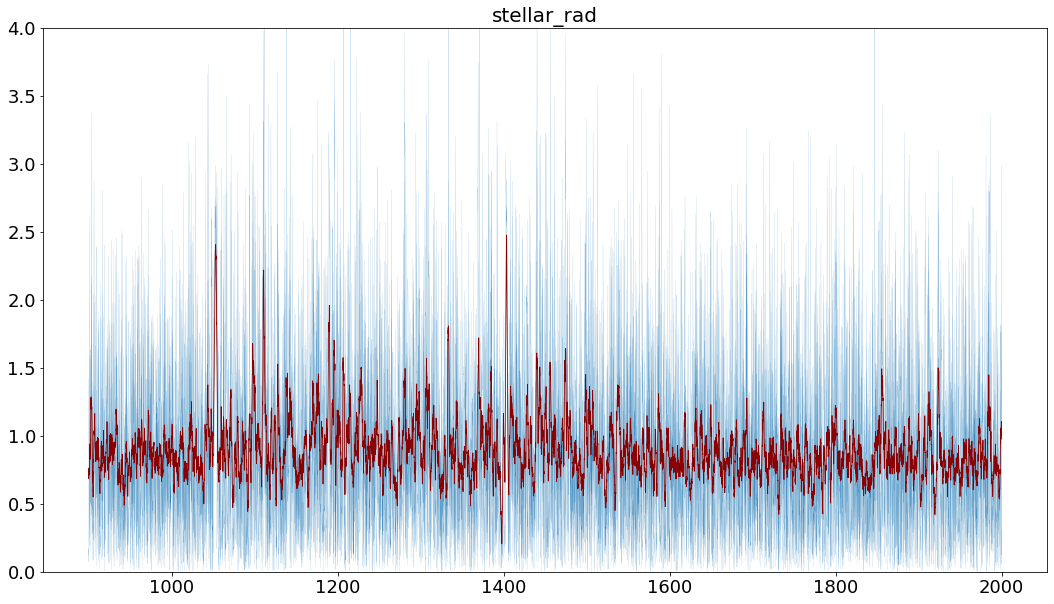

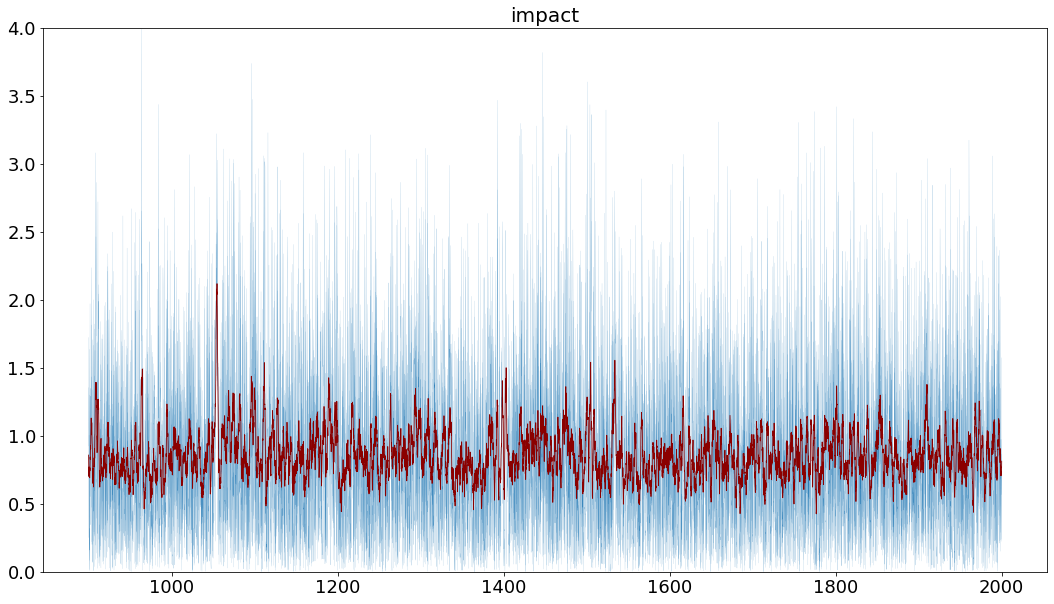

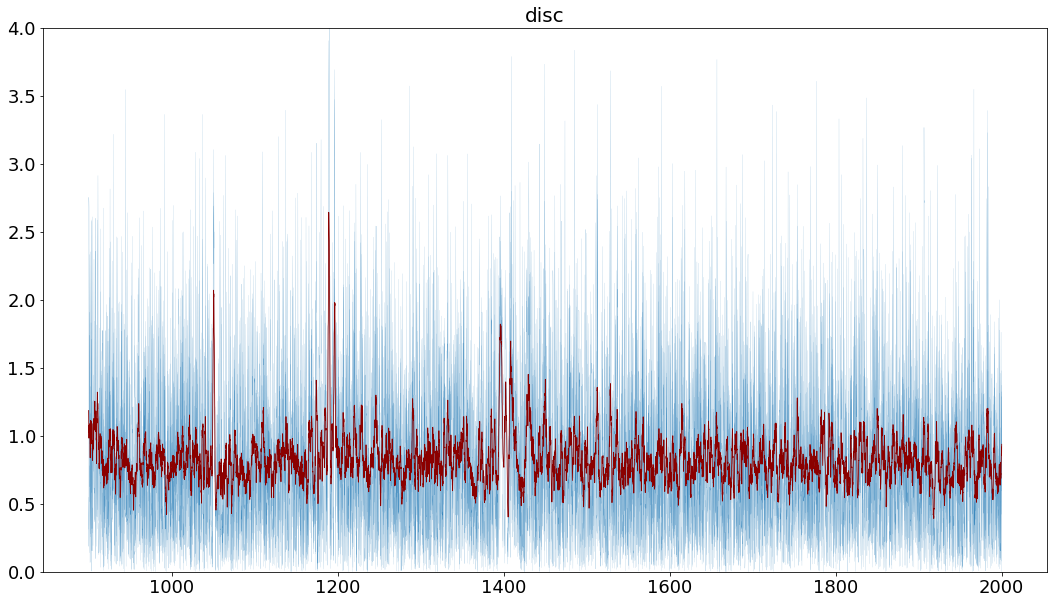

In [39]:
# Plot z-scores of absolute coefficients of regressions

for i in np.arange(0, 4):

    print(phys_val.columns[i])
    plot_coefs_vs_wavelength( np.abs(coefs_array[i+1,:])/(std_array[i+1,:]), 20, 10, title = phys_val.columns[i], 
                             xticks = data_dict["wavelengths"], color_ma = "darkred", y_lim = [0, 4]) 
#     plot_coefs_vs_wavelength( (coefs_array[i+1,:]), 20, 10, title = phys_val.columns[i], 
#                              xticks = data_dict["wavelengths"], color_ma = "darkred") 

virial_rad


()

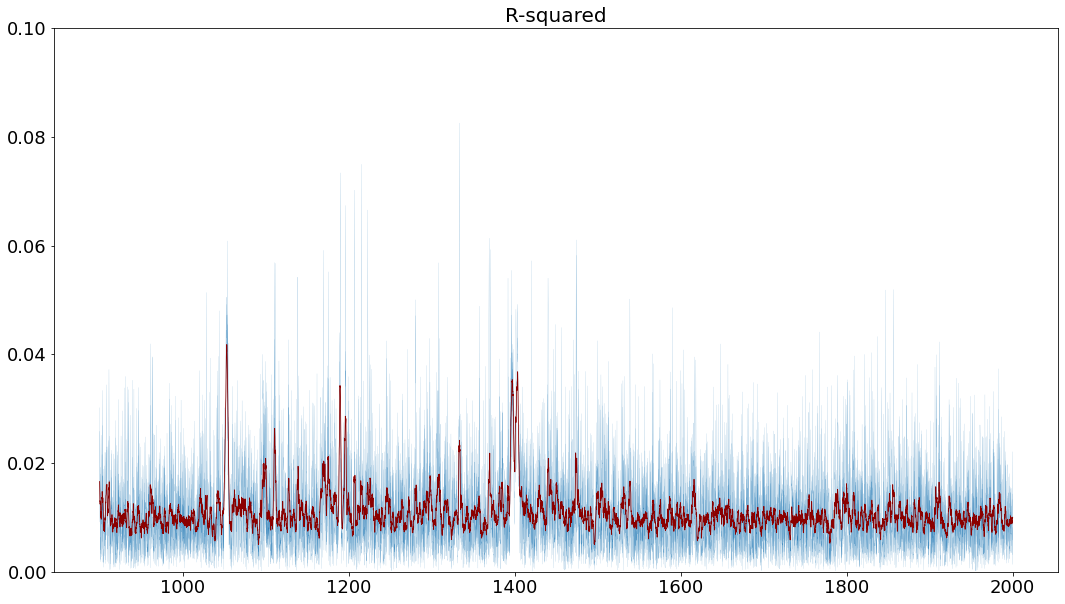

In [40]:
# Plot R-squared of refressions

i = 0
print(phys_val.columns[i])
plot_coefs_vs_wavelength( rsquared_array, 20, 10, title = "R-squared", xticks = data_dict["wavelengths"],
                        color_ma = "darkred", y_lim = [0, 0.1]) 

In [58]:
# i = 1
# print(phys_val.columns[i])
# plot_coefs_vs_wavelength( (coefs_array[i+1,:])/std_array[i+1,:], 20, 10, title = "Stellar radius", xticks = pooled_wavelengths,
#                         color_ma = "darkred") 

# Autoencoder: errors and physical properties

In [41]:
autoenc_errors_means = np.abs(autoenc_errors).mean(axis = 1)
autoenc_errors_means_std = (np.abs(autoenc_errors_means) - autoenc_errors_means.mean())/autoenc_errors_means.std() 

In [42]:
import statsmodels.api as sm
import numpy as np
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
Y = autoenc_errors_means_std
X = phys_val_std
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

const    8.044780e-17
x1       1.894211e-01
x2       2.326503e-03
x3      -2.976419e-01
x4       2.677355e-01
dtype: float64

In [43]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     29.73
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           8.14e-22
Time:                        12:36:09   Log-Likelihood:                -556.61
No. Observations:                 430   AIC:                             1123.
Df Residuals:                     425   BIC:                             1144.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.045e-17      0.043   1.88e-15      1.0

In [44]:
coefs_array_autoenc = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
pvals_array_autoenc = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
std_array_autoenc = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
rsquared_array_autoenc = np.empty(shape = val_df_pooled_rescaled.shape[1])

for feature_num in np.arange(0, val_df_pooled_rescaled.shape[1]):
    
    feature = autoenc_errors.iloc[:, feature_num]
    
    feature_std = ( feature - feature.mean() )/ feature.std()
    X = phys_val_std
    X = sm.add_constant(X)
    
    Y = feature_std
    model = sm.OLS(Y,X)
    results = model.fit()
    
    coefs_array_autoenc[:, feature_num] = results.params
    std_array_autoenc[:, feature_num] = results.bse
    pvals_array_autoenc[:, feature_num] = results.pvalues
    rsquared_array_autoenc[feature_num] = results.rsquared

virial_rad


()

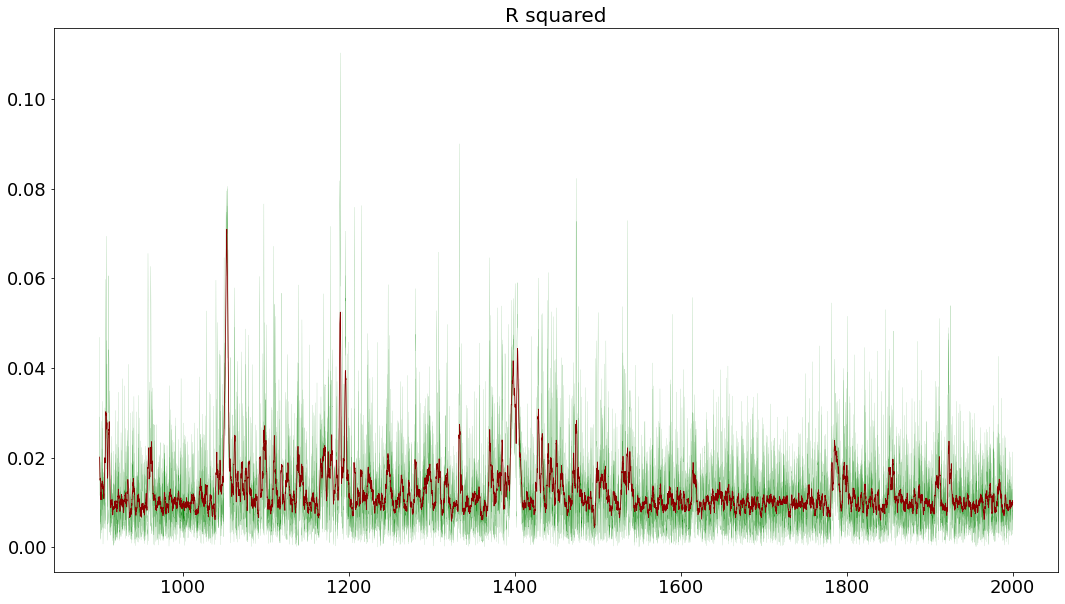

In [46]:
# R-squared

i = 0
print(phys_val.columns[i])
plot_coefs_vs_wavelength( rsquared_array_autoenc, 20, 10, title = "R squared", xticks = data_dict["wavelengths"],
                        color = "green", color_ma = "darkred") 

virial_rad
stellar_rad
impact
disc


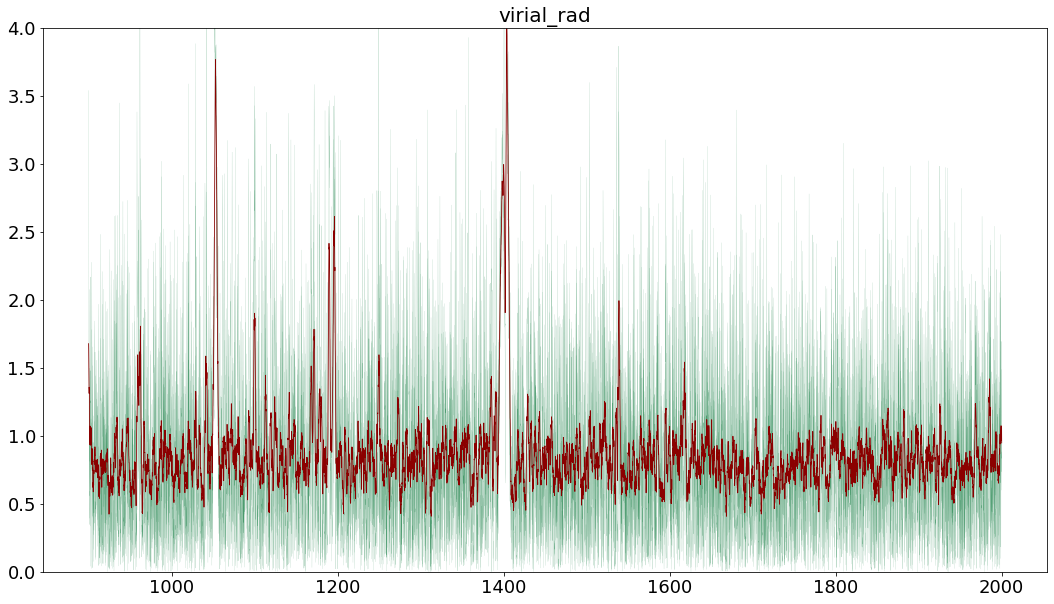

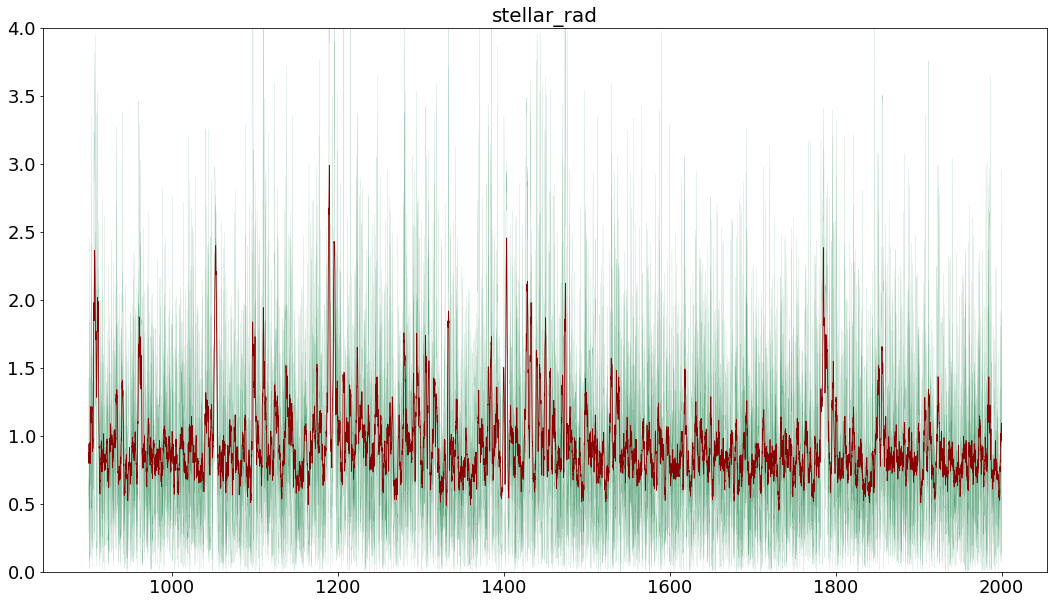

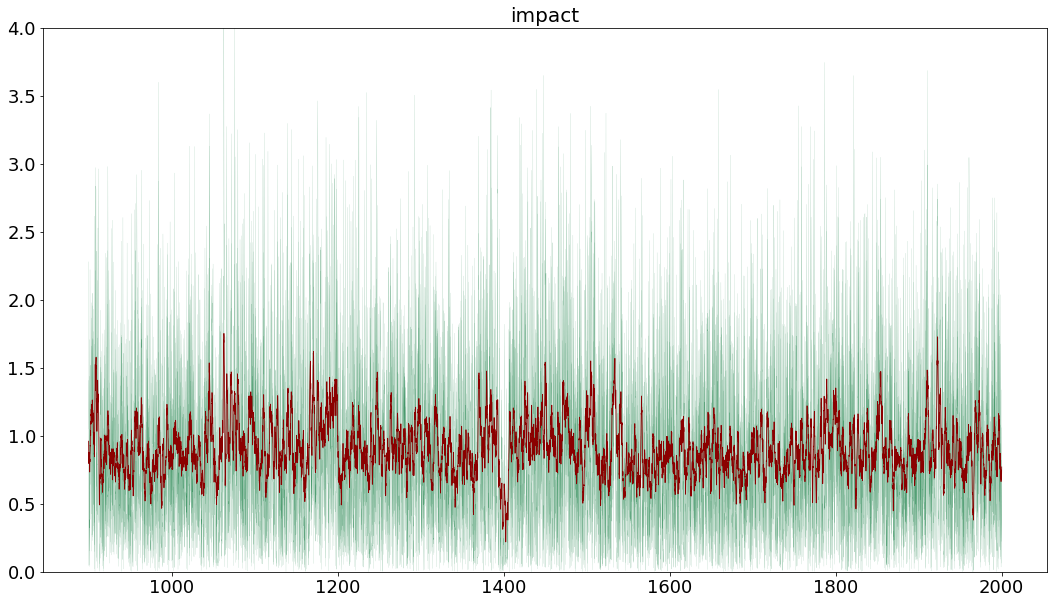

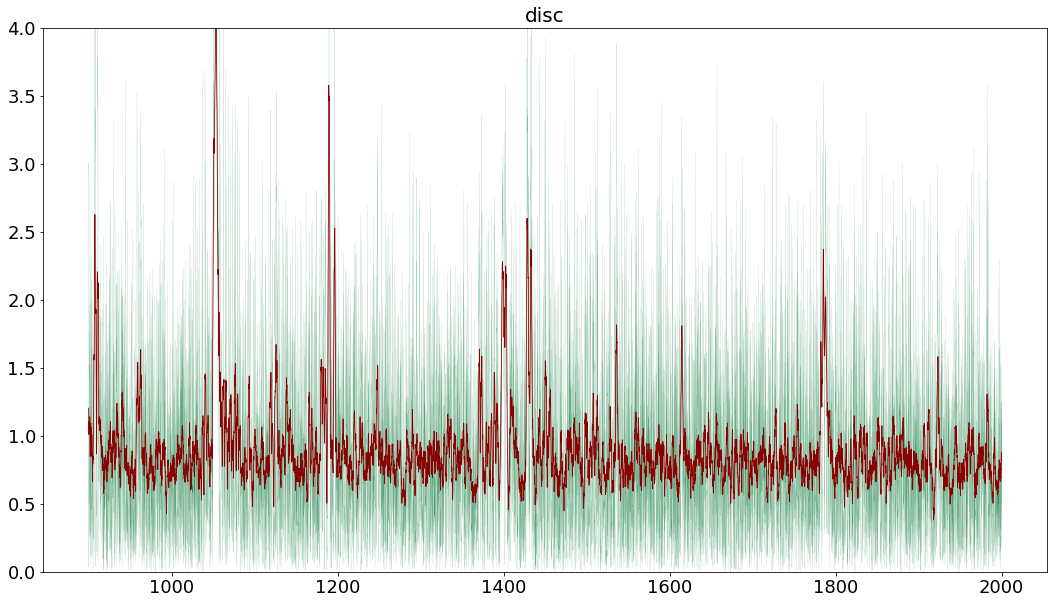

In [47]:
# Z-score of absolute coefficients

for i in np.arange(0, 4):

    print(phys_val.columns[i])
    plot_coefs_vs_wavelength( np.abs(coefs_array_autoenc[i+1,:])/std_array_autoenc[i+1,:], 20, 10, title = phys_val.columns[i], 
                             xticks = data_dict["wavelengths"], color = "seagreen", color_ma = "darkred", y_lim = [0, 4]) 
#     plot_coefs_vs_wavelength( (coefs_array_autoenc[i+1,:]), 20, 10, title = phys_val.columns[i], 
#                              xticks = data_dict["wavelengths"], color = "seagreen", color_ma = "darkred") 

 # Spectra and physical properties

Repeat the same analysis as above, but nor taking the spectral lines as Y -> this will gives us an idea how much do dim. reduction methods studied above capture of the dependence on physical data.

In [48]:
coefs_array_features = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
pvals_array_features = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
std_array_features = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
rsquared_array_features = np.empty(shape = val_df_pooled_rescaled.shape[1])

for feature_num in np.arange(0, val_df_pooled_rescaled.shape[1]):
    
    feature = val_df_pooled_rescaled.iloc[:, feature_num]
    
    feature_std = ( feature - feature.mean() )/ feature.std()
    X = phys_val_std
    X = sm.add_constant(X)
    
    Y = feature_std
    model = sm.OLS(Y,X)
    results = model.fit()
    
    coefs_array_features[:, feature_num] = results.params
    pvals_array_features[:, feature_num] = results.pvalues
    rsquared_array_features[feature_num] = results.rsquared
    std_array_features[:, feature_num] = results.bse

virial_rad
stellar_rad
impact
disc


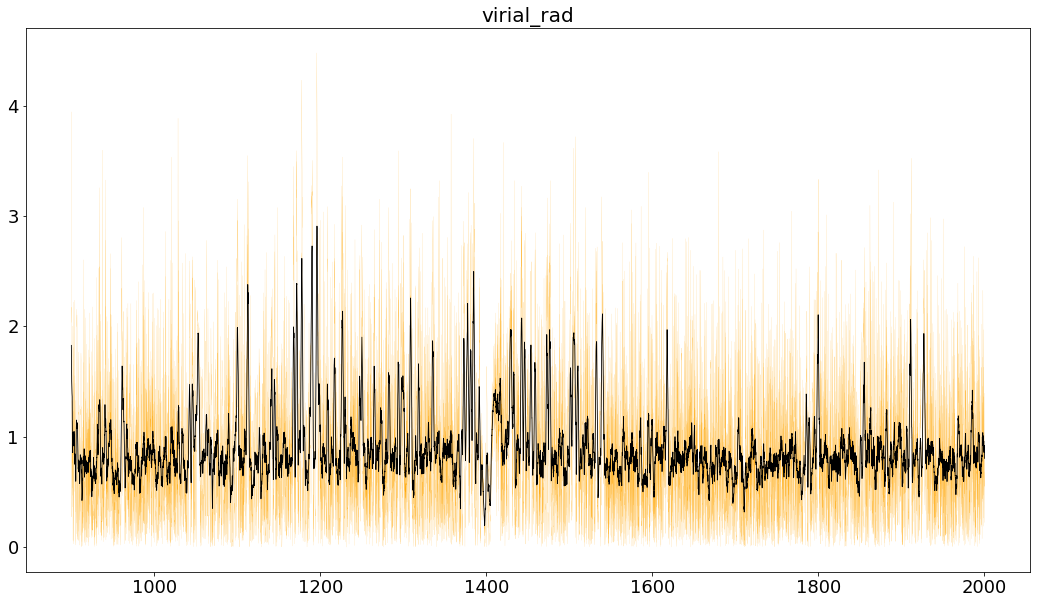

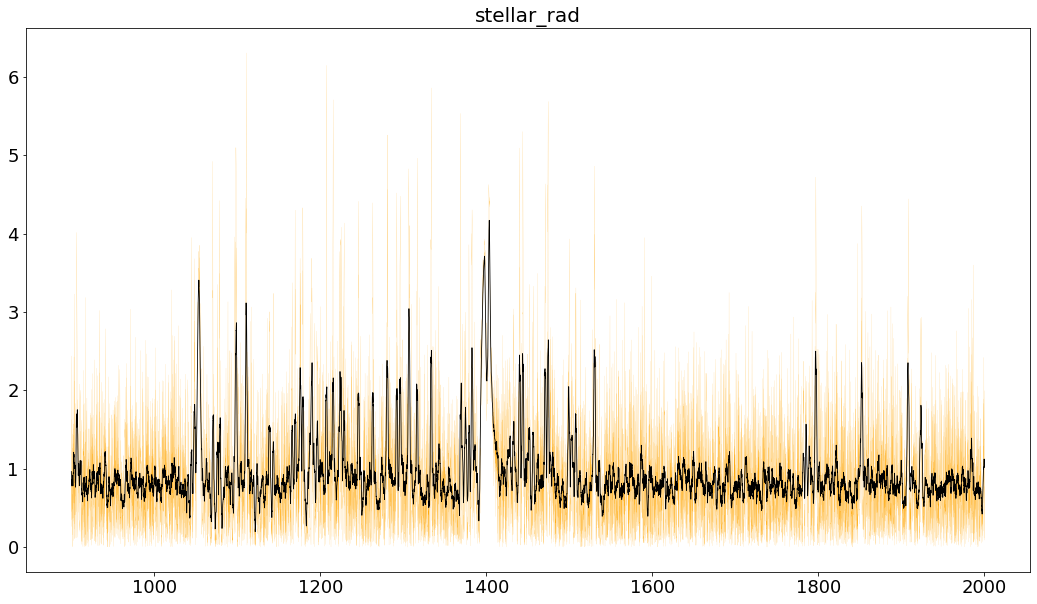

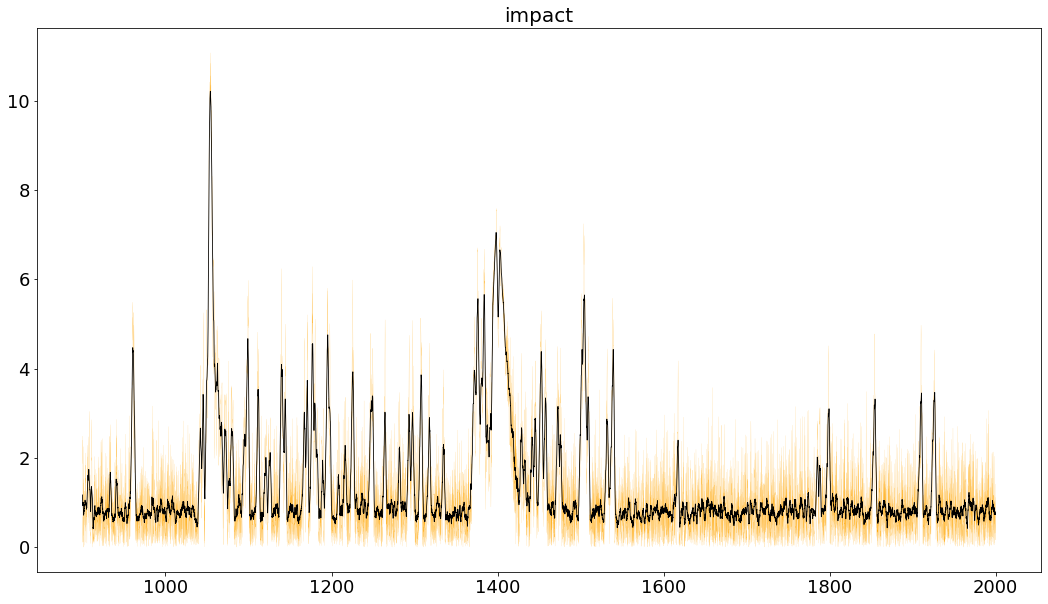

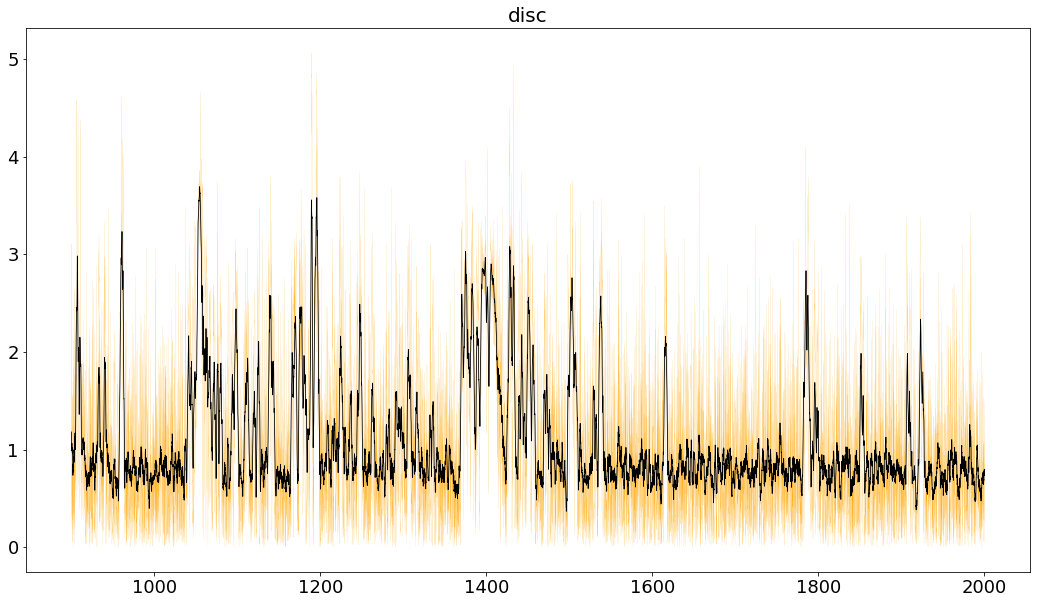

In [49]:
for i in np.arange(0, 4):

    print(phys_val.columns[i])
    plot_coefs_vs_wavelength( np.abs(coefs_array_features[i+1,:])/(std_array_features[i+1,:]), 20, 10, title = phys_val.columns[i], 
                             xticks = data_dict["wavelengths"], color = "orange", color_ma = "black") 
#     plot_coefs_vs_wavelength( (coefs_array_features[i+1,:]), 20, 10, title = phys_val.columns[i], 
#                              xticks = data_dict["wavelengths"], color = "orange", color_ma = "black") 

virial_rad


()

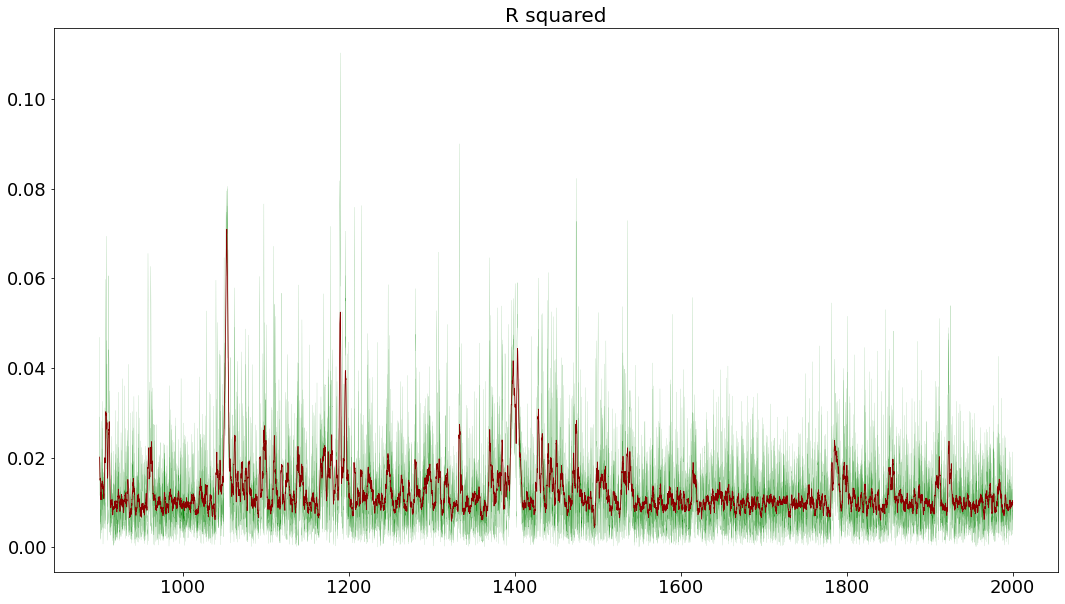

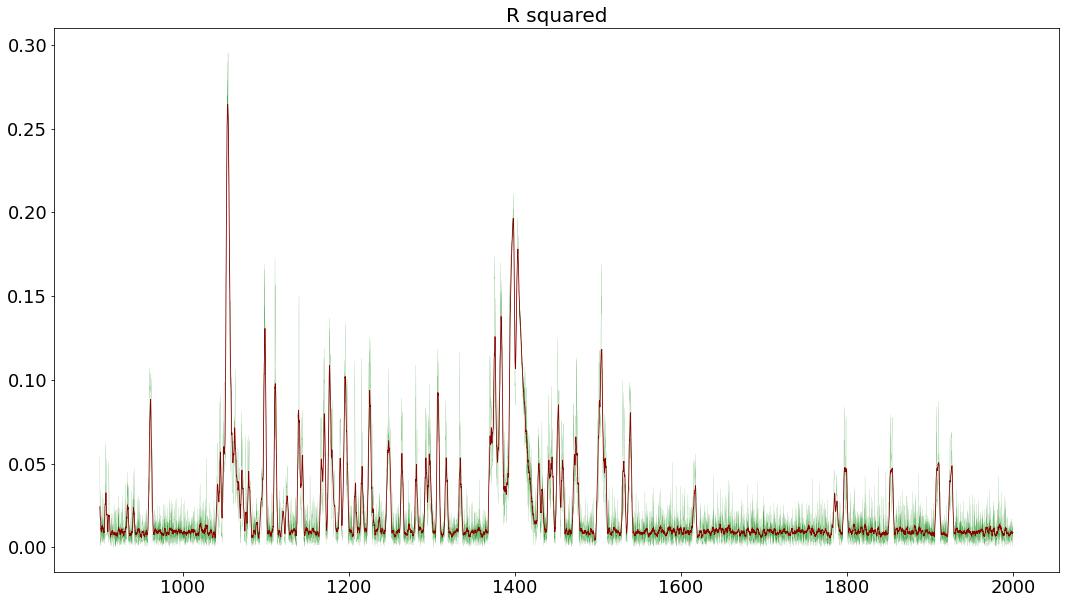

In [70]:
i = 0
print(phys_val.columns[i])
plot_coefs_vs_wavelength( rsquared_array_autoenc, 20, 10, title = "R squared", xticks = data_dict["wavelengths"],
                        color = "green", color_ma = "darkred") 
plot_coefs_vs_wavelength( rsquared_array_features, 20, 10, title = "R squared", xticks = data_dict["wavelengths"],
                        color = "green", color_ma = "darkred") 

## PCA and AE errors: comparison

Text(0, 0.5, 'PCA R-squared')

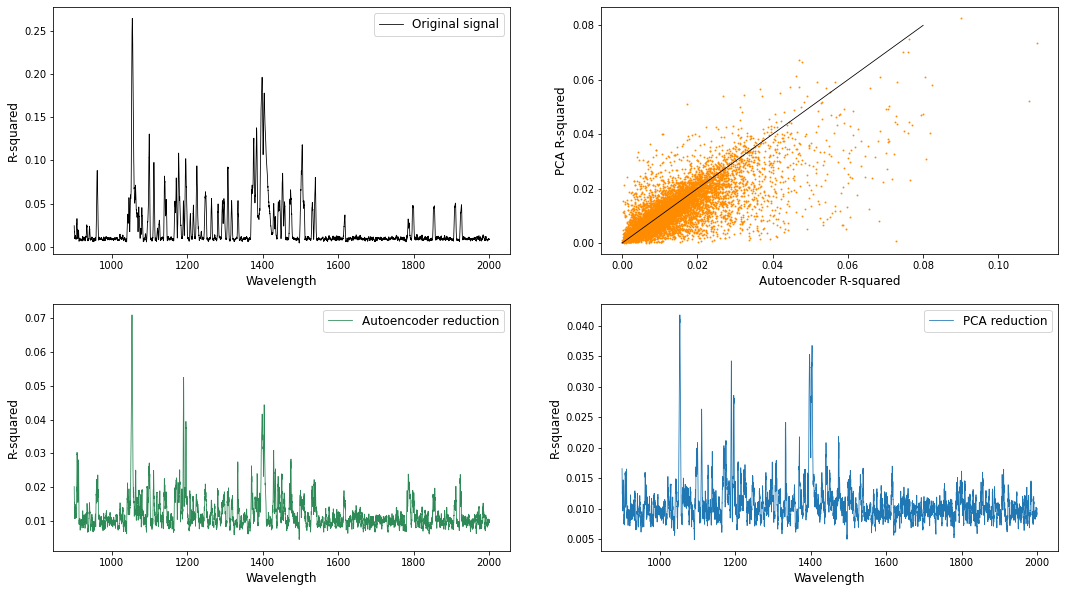

In [69]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))

ax[0, 0].plot(numpy_rolling_mean(rsquared_array_features, 20, 10, data_dict["wavelengths"]), 
        linewidth=0.8, 
        color = "black", label = "Original signal" );
ax[0, 0].set_ylabel("R-squared", fontsize = 12)
ax[0, 0].set_xlabel("Wavelength", fontsize = 12)
ax[0, 0].legend(fontsize = 12)

ax[1, 0].plot(numpy_rolling_mean(rsquared_array_autoenc, 20, 10, data_dict["wavelengths"]), 
        linewidth=0.8, 
        color = "seagreen", label = "Autoencoder reduction" );
ax[1, 0].set_ylabel("R-squared", fontsize = 12)
ax[1, 0].set_xlabel("Wavelength", fontsize = 12)
ax[1,0].legend(fontsize = 12)

ax[1, 1].plot(numpy_rolling_mean(rsquared_array, 20, 10, data_dict["wavelengths"]), 
        linewidth=0.8, label = "PCA reduction" );
ax[1, 1].set_ylabel("R-squared", fontsize = 12)
ax[1, 1].set_xlabel("Wavelength", fontsize = 12)
ax[1,1].legend(fontsize = 12)

ax[0, 1].scatter(numpy_rolling_mean(rsquared_array_autoenc, 1, 1, data_dict["wavelengths"]), 
          numpy_rolling_mean(rsquared_array, 1, 1, data_dict["wavelengths"]), s = 0.8, c = "darkorange")
ax[0, 1].plot([0, 0.08], [0,0.08], color = "black", linewidth = 0.8)
ax[0, 1].set_xlabel("Autoencoder R-squared", fontsize = 12)
ax[0, 1].set_ylabel("PCA R-squared", fontsize = 12)

# Is error related to total flux within a sample?

In [72]:

total_flux_per_sample = np.abs(val_df_pooled_rescaled-1).sum(axis = 1)
total_flux_per_wavelength = np.abs(val_df_pooled_rescaled-1).sum(axis = 0)

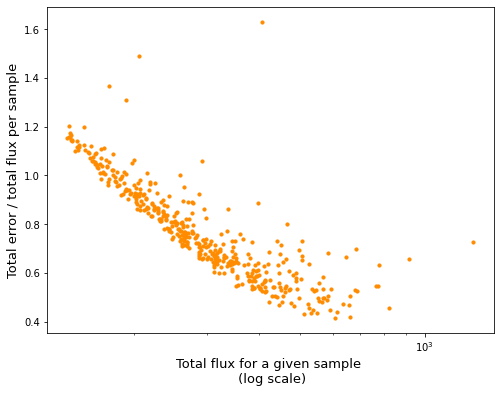

In [74]:
fix, ax = plt.subplots(figsize = (8, 6))
ax.scatter(total_flux_per_sample, np.abs(autoenc_errors).sum(axis = 1)/total_flux_per_sample, s = 10, color = "darkorange")
ax.set_xlabel("Total flux for a given sample \n (log scale)", fontsize = 13)
ax.set_ylabel("Total error / total flux per sample" , fontsize = 13)
# ax.set_yscale('log')
ax.set_xscale('log')

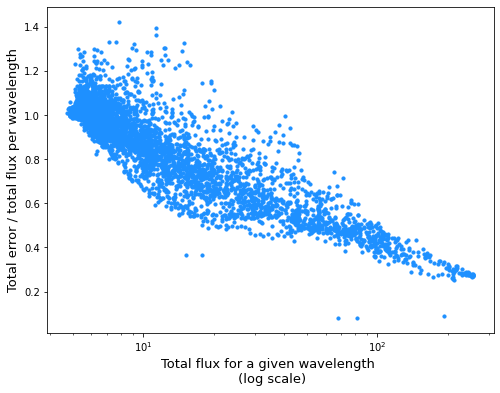

In [75]:
fix, ax = plt.subplots(figsize = (8, 6))
ax.scatter(total_flux_per_wavelength, np.abs(autoenc_errors).sum(axis = 0)/total_flux_per_wavelength, s = 10, color = "dodgerblue")
ax.set_xlabel("Total flux for a given wavelength \n (log scale)", fontsize = 13)
ax.set_ylabel("Total error / total flux per wavelength", fontsize = 13)
ax.set_xscale('log')